### Step 0. Library Load

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

### Step 1. DataLoader

In [3]:
class dataLoader:
    def __init__(self, data):
        self.data = data
        self.rewind()

    def next(self):
        try:
            return self.generator.__next__()
        except StopIteration:
            raise StopIteration

    def rewind(self):
        self.generator = (row for row in self.data)


df = np.genfromtxt("Tick_sample.csv", delimiter=",", dtype=float)
df_generator = dataLoader(df)

### Step2. Env Setting

-  Market Making Notation
    1. Limit Order Book : 시장 참여자들의 매수와 매도 Quotation을 모아둔 테이블
    2. Buy Order table : 주식을 매수하려는 사람들이 Quotation한 매수 주문 정보가 있는 테이블
    3. Sell Order table : 주식을 매도하려는 사람들이 Quotation한 매도 주문 정보가 있는 테이블
    4. bid price(b) : 희망 매수 가격
    5. ask price(a) : 희망 매도 가격
    6. bid-ask price : max(bid price) - min(ask price)
    
- Reference
    1. https://brunch.co.kr/@kisunyoon/50


- LET X = Inventory of orderbook. then, X $\in$ {Long, Short, flat}
- LET t is max time. 
- LET O is order book table. and P is price. then, we can define the order book depth. {$O_{time}^{ask}$, $q_{time}^{ask}$, $O_{time}^{bid}$, $q_{time}^{bid}$}

In [4]:

class Env:
    def __init__(self):
        self.transaction_cost = 0.0015                                                 # 거래 비용
        self.Action_dict  = {'buy': 2, 'sell': 0, 'hold': 1}                           # 행동 집합 
        self.Pos_dict = {'flat': 0, 'long': 2, 'short': 1}                             # 포지션 집합
        self.Action = [0,1,2]                                                          # 행동 
        
        self.Num_inven = 3                                                             # LET X \in Long, short, Flat
        self.Num_prob = 10                                                             # it is grid point 
        self.Dim_Q = (self.Num_inven, self.Num_prob, len(self.Action))                 # 3 * 10 [(Flat, Short, long) * (ten grid points)], 3 
        self.Prob = np.linspace(0, 1, 10)                                              # 그리드 포인트의 간격들 
        self.Max_time = np.float("inf")                                                # t는 계속 가고 error 뜨면 그때 다음에피소드로 넘기기

    def get_state_pos(self, generated_data = df_generator):
        """
        state를 가지고 오는 함수.
        
        q는 order book의 depth로 이 값에 따라서 bid와 ask의 상태를 살펴볼 수 있음. 만약 q가 0으로 간다면 주가가 오른다고 생각하면됨
        
        q는 [0, 1]이므로 얼마나 호가창이 올라가는지를 index로 저장함. 
        
        초기 상태에서는 아무런 postion을 취하지 않아야함.
        
        """
        generated_data.rewind()

        pos = self.Pos_dict["flat"] # 0으로 return 
        entry_price = None

        ask, ask_dep, bid, bid_dep = generated_data.next()
        price = {"bid" : bid / 1000.0, "ask" : ask / 1000.0}

        q = bid_dep / (bid_dep + ask_dep)                                               
        q_index = np.int(q * self.Num_prob)

        state = pos, q_index, price, entry_price

        return state


    def move(self, state, action, generated_data = df_generator):
        pos, q_ind, price, entry_price = state
        reward = 0
        pnl = 0
        done = False

        if self.Prob[q_ind] < random.uniform(0, 1):   # bid와 ask간의 차이를 보여주는건 항상 0과 1사이임 . 참고 10개구간으로 나눔.
            fill_bid, fill_ask = True, False
        else:
            fill_bid, fill_ask = False, True

        if (action == self.Action_dict["buy"]) and (fill_bid):             # 만약 action이 buy이고 bid에 호가가 쌓여있다면 즉, 매수 주문이 엄청많은 상태
            reward =  -self.transaction_cost                               # 즉각적으로 buy에 대한 거래비용을 줘라
            
            if (pos == self.Pos_dict["flat"]):                             # 그런데 현재 포지션이 flat 인상태이면 long으로 바꾸고
                pos = self.Pos_dict["long"]                                # bid price에 entry해라.
                entry_price = price["bid"]

            elif (pos == self.Pos_dict["short"]):                          # 그런데 현재 포지션이 short이면 flat으로 바꾸고 
                pos = self.Pos_dict["flat"]                                # 현재 bid price로 팔아서 이득을 취해라.
                exit_price = price["bid"]
                pnl = entry_price - exit_price
                entry_price = None
            else:
                raise ValueError("Can't buy")

        if (action == self.Action_dict["sell"]) and (fill_ask):            # 만약 action이 sell이고 ask에 호가가 쌓여있다면 즉, 매도 주문이 엄청많은 상태
            reward = -self.transaction_cost                                # 즉각적으로 buy에 대한 거래비용을 줘라

            if (pos == self.Pos_dict["flat"]):                             # 그런데 현재 포지션이 flat 인상태이면 short으로 바꾸고
                pos = self.Pos_dict["short"]                               # ask price에 entry해라.
                entry_price = price["ask"]

            elif (pos == self.Pos_dict["long"]):                           # 그런데 현재 포지션이 long이면 flat으로 바꾸고 
                pos = self.Pos_dict["flat"]                                # ask price로 exit해라.
                exit_price  = price["ask"]
                pnl = -(entry_price - exit_price)
                entry_price = None
            else:
                raise ValueError("Can't sell")

        reward += pnl

        try:
            ask, ask_depth, bid, bid_depth = generated_data.next()
            price = {'bid': bid/1000.0, 'ask': ask/1000.0}
            q = bid_depth / (bid_depth + ask_depth)
            q_ind = np.int(q * self.Num_prob)

        except StopIteration:
            raise StopIteration

        next_state = pos, q_ind, price, entry_price
        return next_state, reward

    def how_to_choose_a(self, state, q, eps):
        """
        it use Machine learning in fincace CODE
        pages 347--416
        """
        pos, q_ind, price, entry_price = state

        if np.random.binomial(1, eps) == 1:
            if pos == self.Pos_dict["long"]:
                action = np.random.choice([self.Action_dict["hold"], self.Action_dict["sell"]])

            elif pos == self.Pos_dict["short"]:
                action = np.random.choice([self.Action_dict["hold"], self.Action_dict["buy"]])

            else:
                action = np.random.choice([self.Action_dict["hold"], self.Action_dict["buy"], self.Action_dict["sell"]])

        else:
            if pos == self.Pos_dict["long"]:
                action_ = [self.Action_dict["hold"], self.Action_dict["sell"]]

            elif pos == self.Pos_dict["short"]:
                action_ = [self.Action_dict["hold"], self.Action_dict["buy"]]

            else:
                action_ = [self.Action_dict["hold"], self.Action_dict["buy"], self.Action_dict["sell"]]

            values_ = q[state[0], state[1], action_]

            action = np.random.choice([action_[i] for i, value_ in enumerate(values_) if value_ == np.max(values_)])

        return action

### Step 3. Learning Agent

- Reference
   - 1. https://data-newbie.tistory.com/547


In [7]:
class LearningAgent:
    def __init__(self, alpha = 0.5, eps = 1, gamma = 1):

        self.alpha = alpha
        self.eps = eps
        self.gamma = gamma

    def SARSA(self,  Q ,  eps):

        state =  env.get_state_pos(generated_data=df_generator)

        action = env.how_to_choose_a(state, q = Q, eps = self.eps)
        reward_sum = 0.0
        done = False
        iter = 0

        while (iter < env.Max_time) and not done:
            try:
                next_state, reward = env.move(state, action)
            except StopIteration:
                done = True
                continue
            next_action = env.how_to_choose_a(next_state, q= Q, eps = eps)
            reward_sum += reward

            target = Q[next_state[0], next_state[1], next_action]
            target *= self.gamma

            Q[state[0], state[1], action] += self.alpha * (reward + target - Q[state[0], state[1], action])

            state = next_state
            action = next_action
            iter += 1
        return reward_sum

    def Q_W(self, Q):

        pass



    def DDQN(self, Q, Q2, eps):

        state =  env.get_state_pos(generated_data=df_generator)

        action = env.how_to_choose_a(state, q = Q + Q2, eps = self.eps)
        reward_sum = 0.0
        done = False
        iter = 0

        while (iter < env.Max_time) and not done:
            try:
                next_state, reward = env.move(state, action)
            except StopIteration:
                done = True
                continue
            next_action = env.how_to_choose_a(next_state, q=  Q + Q2, eps = eps)
            reward_sum += reward

            if random.uniform(0, 1) <= 0.5:
                target1 = Q2[next_state[0], next_state[1], next_action]
                target1 *= self.gamma
                Q[state[0], state[1], action] += self.alpha *(reward + target1 - Q[state[0], state[1], action])

            else:
                target2 = Q[next_state[0], next_state[1], next_action]
                target2 *= self.gamma
                Q2[state[0], state[1], action] += self.alpha *(reward + target2 - Q2[state[0], state[1], action])


            state = next_state
            action = next_action
            iter += 1
        return reward_sum


    def ESARSA(self,  Q, eps):

        state =  env.get_state_pos(generated_data=df_generator)

        action = env.how_to_choose_a(state, q = Q, eps = self.eps)
        reward_sum = 0.0
        done = False
        iter = 0

        while (iter < env.Max_time) and not done:
            try:
                next_state, reward = env.move(state, action)
            except StopIteration:
                done = True
                continue
            next_action = env.how_to_choose_a(next_state, q= Q, eps = eps)
            reward_sum += reward

            target = 0.0
            q_next = Q[next_state[0], next_state[1], :]
            best_actions = np.argwhere(q_next == np.max(q_next))
            for i in env.Action:
                if i in best_actions:
                    target += ((1.0 - eps) / len(best_actions) + eps / len(env.Action_dict)) * Q[next_state[0], next_state[1], i]
                else:
                    target += eps / len(env.Action_dict) * Q[next_state[0], next_state[1], i]
            target *= self.gamma

            # SARSA update
            Q[state[0], state[1], action] += self.alpha * (reward + target - Q[state[0], state[1], action])

            state = next_state
            action = next_action
            iter += 1
        return reward_sum



    def Q_learning(self, Q, eps):

        reward_sum = 0.0
        done = False
        iter = 0

        state = env.get_state_pos(generated_data=df_generator)

        while (iter < env.Max_time) and not done:
            action = env.how_to_choose_a(state, Q, eps = eps)

            try:
                next_state, reward = env.move(state, action)
            except StopIteration:
                done = True
                continue

            reward_sum += reward

            # Q-Learning update
            Q[state[0], state[1], action] += self.alpha * (reward + self.gamma * np.max(Q[next_state[0], next_state[1], :]) - Q[state[0], state[1], action])
            state = next_state
            iter += 1
        return reward_sum




    def print_optimal_policy(self, Q):
        """
        it use Machine learning in fincace CODE
        pages 347--416
        """
        optimal_policy = np.argmax(Q, axis=-1)
        print("ask fill prob:", *['%.2f' % q for q in env.Prob])

        for i in range(0, env.Num_inven):

            str_ = ""
            if (i == 0):
                str_ += '         flat     '
            elif (i == 1):
                str_ += '        short     '
            else:
                str_ += '         long     '

            for j in range(0, env.Num_prob):
                a = np.int(optimal_policy[i, j])
                if a == 0:
                    str_ += 's    '
                elif a == 1:
                    str_ += 'h    '
                else:
                    str_ += 'b    '
            print(str_)


    def train(self, policy, episodes=100):
        if policy == 'sarsa':
            learning_alg = self.SARSA
        elif policy == 'qlearning':
            learning_alg = self.Q_learning
        elif policy == "esarsa":
            learning_alg = self.ESARSA
        elif policy == "ddqn":
            learning_alg = self.DDQN
        else:
            raise ValueError("choose 'sarsa', 'esarsa', 'ddqn' or 'q-learning'")

        epoch_length = 15

        # Initialise the rewards vector and state-action values array
        reward_sum = np.zeros(episodes)
        q_value = np.zeros(env.Dim_Q)
        q_value_2 = np.zeros(env.Dim_Q)

        print('Training {}...'.format(policy))

        if policy != "ddqn":
            print("Lets {} Algorithm".format(policy))
            for i in range(0, episodes):
                eps = self.eps * ((1 - self.eps) ** (i // epoch_length))
                reward_sum[i] = learning_alg(Q = q_value, eps = eps)

        else:
            print("Lets DDQN Algorithm")
            for i in range(0, episodes):
                eps = self.eps * ((1 - self.eps) ** (i // epoch_length))
                reward_sum[i] = learning_alg(Q = q_value, Q2 = q_value_2, eps = eps)

        return q_value, reward_sum


### Step4. Result

Training sarsa...
Lets sarsa Algorithm
Training esarsa...
Lets esarsa Algorithm
Training qlearning...
Lets qlearning Algorithm
Training ddqn...
Lets DDQN Algorithm
SARSA
ask fill prob: 0.00 0.11 0.22 0.33 0.44 0.56 0.67 0.78 0.89 1.00
         flat     b    s    b    s    h    s    b    s    s    s    
        short     h    b    b    b    b    b    b    b    b    b    
         long     s    h    s    h    h    s    s    s    s    s    
ESARSA
ask fill prob: 0.00 0.11 0.22 0.33 0.44 0.56 0.67 0.78 0.89 1.00
         flat     h    h    h    s    b    b    s    b    b    h    
        short     b    b    b    b    b    b    b    b    b    h    
         long     h    s    s    s    s    s    s    s    h    s    
Q-learning
ask fill prob: 0.00 0.11 0.22 0.33 0.44 0.56 0.67 0.78 0.89 1.00
         flat     h    b    b    h    b    s    s    s    s    s    
        short     h    b    h    b    b    b    h    h    h    h    
         long     s    s    s    s    s    s    s    h    s    s 

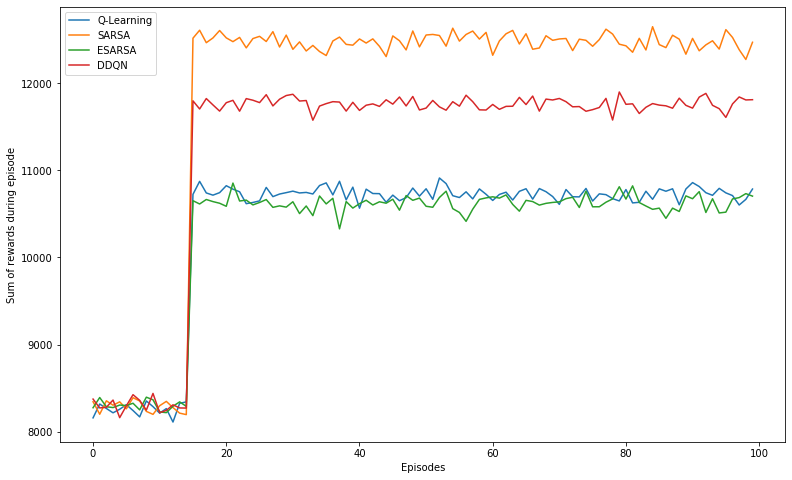

In [8]:
if __name__ == '__main__':
    env = Env()

    q_value_example = np.random.random(env.Dim_Q)
    state  = env.get_state_pos(df_generator)
    RUN = LearningAgent()

    q_sarsa, rewards_sarsa = RUN.train("sarsa")
    e_q_sarsa, e_rewards_sarsa = RUN.train("esarsa")
    q_q_learning, rewards_q_learning = RUN.train("qlearning")


    ddqn, rewards_ddqn = RUN.train("ddqn")

    print('SARSA')
    RUN.print_optimal_policy(q_sarsa)

    print('ESARSA')
    RUN.print_optimal_policy(e_q_sarsa)

    print('Q-learning')
    RUN.print_optimal_policy(q_q_learning)

    print('DOUBLE Q-learning')
    RUN.print_optimal_policy(ddqn)

    plt.figure(figsize=(13, 8))
    plt.plot(rewards_q_learning, label='Q-Learning')
    plt.plot(rewards_sarsa, label='SARSA')
    plt.plot(e_rewards_sarsa, label='ESARSA')
    plt.plot(rewards_ddqn, label='DDQN')

    plt.xlabel('Episodes')
    plt.ylabel('Sum of rewards during episode')
    plt.legend()
    plt.show()
